## PUMS Recoding for the AllOfUs Coding Scheme

This notebook loads a PUMS person-level file (either for a given state or for the entire usa), extracts relevant variables, rebins them, and writes out a CSV file containing the recoded variables. The coding scheme is that of the AllOfUs data.

Place the input file in a `data` folder in the current directory.

The recoded data will be written to a file of the same name in the `data` folder, but with `_recoded` prior to the extension.

In [1]:
import os
import re
import sys
import math
import numpy as np
import pandas as pd

from collections import Counter

from src import pdf, plots, coding_aou as CODING, census_divisions as census

### User Parameters

In [2]:
# where the input file is found
DATA_DIR = 'data'

# preprocessed PUMS file for entire USA
INPUT_FILE_NAME = 'pums_usa_2019.csv'

# whether to adjust income values to constant dollars before recoding
USE_CONSTANT_DOLLARS = True

# columns to extract from the data file
KEEP_COLS = [
    'ST',       # state identifier (also includes DC)
    'SERIALNO', # essentially the household ID
    'SPORDER',  # unique ID for each person within a given household
    'AGEP',     # numeric age, 0..99
    'PWGTP',    # person-level weight
    'ADJINC',   # income adustment factor
    'HISP',     # recoded detailed Hispanic origin (01 == not Spanish/Hispanic/Latino)
    'RAC1P',    # detailed race code
    'SCHL',     # educational attainment
    'HICOV',    # health insurance recode
    'PINCP',    # total person's income (use ADJINC to adjust to constant dollars)
    'SEX',      # sex (at birth, presumably)
]

#### Load the input file

In [3]:
INPUT_FILE = os.path.join(DATA_DIR, INPUT_FILE_NAME)
print('Loading file "{0}"...'.format(INPUT_FILE))
raw_df = pd.read_csv(INPUT_FILE)
raw_df

Loading file "data/pums_usa_2019.csv"...


,ST,SERIALNO,SPORDER,AGEP,ADJINC,PWGTP,HISP,RAC1P,SCHL,HICOV,PINCP,SEX
0,1,2019HU1259536,4,10,1010145,185,1,2,7.0,1,NaN,1
1,1,2019HU0915454,2,17,1010145,77,1,1,13.0,1,10000.0,2
2,1,2019HU0915504,1,46,1010145,23,2,1,19.0,1,94600.0,1
3,1,2019HU0915555,1,69,1010145,71,1,1,16.0,1,37100.0,2
4,1,2019HU0915555,2,72,1010145,53,1,1,21.0,1,8400.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3239548,56,2019HU1000576,2,56,1010145,134,1,1,18.0,1,0.0,2
3239549,56,2019HU1000576,3,17,1010145,141,1,1,14.0,1,0.0,1
3239550,56,2019HU1000791,1,66,1010145,24,1,1,16.0,1,13900.0,2
3239551,56,2019HU0999472,1,33,1010145,48,2,1,21.0,1,33700.0,2


In [4]:
# determine whether this is a file for a single state or the entire USA
unique_state_count = len(set(raw_df['ST'].values))
assert unique_state_count >= 1
assert unique_state_count <= 51 # DC is in the file also
single_state_file = 1 == unique_state_count

print('Single state file: {0}'.format(single_state_file))

if single_state_file:
    # check the number of unique people - should have a unique individual per row of the dataframe
    # (concat SERIALNO and SPORDER to make a unique identifier for each person)
    id_set = set()
    for index, row in raw_df.iterrows():
        # household/family ID
        serialno = row['SERIALNO']
        # person id within the household
        person = row['SPORDER']
        key = '{0}|{1}'.format(serialno, person)
        id_set.add(key)
    num_individuals = len(id_set)

    # should have a unique person on each line of the file
    assert num_individuals == raw_df.shape[0]

Single state file: False


#### Extract desired columns

In [5]:
recoded_df = raw_df[KEEP_COLS].copy()
recoded_df

,ST,SERIALNO,SPORDER,AGEP,PWGTP,ADJINC,HISP,RAC1P,SCHL,HICOV,PINCP,SEX
0,1,2019HU1259536,4,10,185,1010145,1,2,7.0,1,NaN,1
1,1,2019HU0915454,2,17,77,1010145,1,1,13.0,1,10000.0,2
2,1,2019HU0915504,1,46,23,1010145,2,1,19.0,1,94600.0,1
3,1,2019HU0915555,1,69,71,1010145,1,1,16.0,1,37100.0,2
4,1,2019HU0915555,2,72,53,1010145,1,1,21.0,1,8400.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3239548,56,2019HU1000576,2,56,134,1010145,1,1,18.0,1,0.0,2
3239549,56,2019HU1000576,3,17,141,1010145,1,1,14.0,1,0.0,1
3239550,56,2019HU1000791,1,66,24,1010145,1,1,16.0,1,13900.0,2
3239551,56,2019HU0999472,1,33,48,1010145,2,1,21.0,1,33700.0,2


#### Drop all individuals who are less than 18 years old

The AllOfUs coding scheme uses a minimum age of 18 years.

In [6]:
recoded_df = recoded_df.loc[recoded_df['AGEP'] >= 18]
recoded_df = recoded_df.reset_index(drop=True)
recoded_df

,ST,SERIALNO,SPORDER,AGEP,PWGTP,ADJINC,HISP,RAC1P,SCHL,HICOV,PINCP,SEX
0,1,2019HU0915504,1,46,23,1010145,2,1,19.0,1,94600.0,1
1,1,2019HU0915555,1,69,71,1010145,1,1,16.0,1,37100.0,2
2,1,2019HU0915555,2,72,53,1010145,1,1,21.0,1,8400.0,1
3,1,2019HU0915664,1,72,25,1010145,1,2,17.0,1,26400.0,2
4,1,2019HU0915711,1,26,38,1010145,1,1,22.0,1,60000.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2599166,56,2019HU1000576,1,51,125,1010145,1,1,18.0,1,54000.0,1
2599167,56,2019HU1000576,2,56,134,1010145,1,1,18.0,1,0.0,2
2599168,56,2019HU1000791,1,66,24,1010145,1,1,16.0,1,13900.0,2
2599169,56,2019HU0999472,1,33,48,1010145,2,1,21.0,1,33700.0,2


In [7]:
# nd1_df = recoded_df[recoded_df['ST'] == 38]
# nd_ages = set(nd1_df['AGEP'].values)
# nd_ages

## Recode Selected Variables

In [8]:
def sum_of_values(ctr):
    """
    Sum the values in the given instance of collections.Counter and return the total.
    """
    
    total = 0
    for k,v in ctr.items():
        total += v
    return total

In [9]:
# map of variable enumerator from the coding file to the name of that column
col_map = {}

#### Age

In [10]:
def recode_age(df):
    """
    Recode the PUMS AGEP field as follows:
    
    class Age(Enum):
        AGE_18_29   = 0  
        AGE_30_39   = 1
        AGE_40_49   = 2
        AGE_50_59   = 3
        AGE_60_69   = 4
        AGE_70_PLUS = 5
    """
    
    age_values = df['AGEP'].values
    
    new_values = []
    for pums_age in age_values:
        # the PUMS age should be in the range [18,99]
        assert pums_age >= 18 and pums_age <= 99
        
        if pums_age >= 70:
            recoded = CODING.Age.AGE_70_PLUS.value
        elif pums_age >= 60:
            recoded = CODING.Age.AGE_60_69.value
        elif pums_age >= 50:
            recoded = CODING.Age.AGE_50_59.value
        elif pums_age >= 40:
            recoded = CODING.Age.AGE_40_49.value
        elif pums_age >= 30:
            recoded = CODING.Age.AGE_30_39.value
        else:
            recoded = CODING.Age.AGE_18_29.value
            
        new_values.append(recoded)
        
    # drop the AGE1P column
    df = df.drop(columns=['AGEP'])
    # insert a new Age column
    df = df.assign(Age = new_values)
    
    ctr = Counter(df['Age'].values)
    assert min(ctr.keys()) >= 0
    assert max(ctr.keys()) < CODING.BIN_COUNTS[CODING.Variables.AGE]
    assert df.shape[0] == sum_of_values(ctr)
    return df

In [11]:
recoded_df = recode_age(recoded_df)
col_map[CODING.Variables.AGE] = 'Age'

#### Collapse Age

In [12]:
recoded_df = CODING.collapse_age(recoded_df, state_col='ST', age_col='Age')

# check

# Connecticut, state code 9
check_values = recoded_df[recoded_df['ST']==9]['Age'].values
ctr = Counter(check_values)
assert 0 not in ctr.keys()
# South Carolina, state code 45
check_values = recoded_df[recoded_df['ST']==45]['Age'].values
ctr = Counter(check_values)
assert 5 not in ctr.keys()
# States in the West North Central census division
check_values = recoded_df[recoded_df['ST'].isin({19, 20, 27, 29, 31, 38, 46})]['Age'].values
ctr = Counter(check_values)
# assert 3 not in ctr.keys()
# assert 4 not in ctr.keys()
# assert 5 not in ctr.keys()
assert 0 not in ctr.keys()
assert 1 not in ctr.keys()
assert 3 not in ctr.keys()

#### Race / Ethnicity

In [13]:
def recode_race_eth(df):
    """
    Recode the PUMS RAC1P and HISP fields as follows:
    
    class RaceEth(Enum):
        NH_WHITE = 0  # Non-Hispanic White only
        NH_BLACK = 1  # Non-Hispanic Black only 
        NH_ASIAN = 2  # Non-Hispanic Asian only
        HISPANIC = 3  # Hispanic
        OTHER    = 4  # Other
    """
    
    race_values = df['RAC1P'].values
    hisp_values = df['HISP'].values
    
    new_values = []
    for i, pums_race in enumerate(race_values):
        # pums RAC1P value >= 1 and <= 9
        assert pums_race >= 1 and pums_race <= 9
        
        # check if hispanic or not
        is_hispanic = 1 != hisp_values[i]
        
        if is_hispanic:
            recoded_race = CODING.RaceEth.HISPANIC.value
        else:
            if 1 == pums_race:
                # NH white
                recoded_race = CODING.RaceEth.NH_WHITE.value
            elif 2 == pums_race:
                # NH black
                recoded_race = CODING.RaceEth.NH_BLACK.value
            elif 6 == pums_race:
                # NH asian
                recoded_race = CODING.RaceEth.NH_ASIAN.value
            else:
                # other
                recoded_race = CODING.RaceEth.OTHER.value
                
        new_values.append(recoded_race)
        
    df = df.drop(columns=['RAC1P'])
    df = df.drop(columns=['HISP'])
    df = df.assign(RaceEth = new_values)
    
    ctr = Counter(df['RaceEth'].values)
    assert min(ctr.keys()) >= 0
    assert max(ctr.keys()) < CODING.BIN_COUNTS[CODING.Variables.RACE_ETH]
    assert df.shape[0] == sum_of_values(ctr)
    return df    

In [14]:
recoded_df = recode_race_eth(recoded_df)
col_map[CODING.Variables.RACE_ETH] = 'RaceEth'

#### Collapse RaceEth

In [15]:
recoded_df = CODING.collapse_raceeth(recoded_df, 'ST', 'RaceEth')

# check

# CT, TN, DIV_ESC, DIV_WSC
check_values = recoded_df[recoded_df['ST'].isin({9, 47, 1, 21, 28, 5, 22, 40, 48})]['RaceEth'].values
ctr = Counter(check_values)
assert 2 not in ctr.keys()
# South Carolina, state code 45
check_values = recoded_df[recoded_df['ST']==45]['RaceEth'].values
ctr = Counter(check_values)
assert 2 not in ctr.keys()
assert 4 not in ctr.keys()
# LA and MS, codes 22 and 28
check_values = recoded_df[recoded_df['ST'].isin({22, 28})]['RaceEth'].values
ctr = Counter(check_values)
assert 2 not in ctr.keys()
assert 3 not in ctr.keys()

#### Education

In [16]:
def recode_education(df):
    """
    Recode the PUMS SCHL field as follows:
    
    class Education(Enum):
        COLLEGE_GRAD = 0  # College grad (includes "Missing")
        SOME_COLLEGE = 1  # Some college
        HS_GRAD      = 2  # High school graduate
        NOT_HS_GRAD  = 3  # Not a HS graduate

    """
    
    values = df['SCHL'].values
    
    new_values = []
    for pums_educ in values:
        if np.isnan(pums_educ):
            # missing
            recoded_educ = CODING.Education.COLLEGE_GRAD.value
        elif str == type(pums_educ) and 'bb' == pums_educ:
            # less than 3 years old, code as not a HS graduate
            recoded_educ = CODING.Education.NOT_HS_GRAD.value
        else:
            if pums_educ >= 20:
                # college graduate: associate degree or higher
                recoded_educ = CODING.Education.COLLEGE_GRAD.value
            elif pums_educ >= 18:
                # some college
                recoded_educ = CODING.Education.SOME_COLLEGE.value
            elif pums_educ >= 16:
                # HS diploma or GED
                recoded_educ = CODING.Education.HS_GRAD.value
            else:
                # not a HS graduate
                recoded_educ = CODING.Education.NOT_HS_GRAD.value
                
        new_values.append(recoded_educ)
                
    # drop the 'SCHL' column
    df = df.drop(columns=['SCHL'])
    # insert a new 'Education' column with the recoded values
    df = df.assign(Education = new_values)
    
    ctr = Counter(df['Education'].values)
    assert min(ctr.keys()) >= 0
    assert max(ctr.keys()) < CODING.BIN_COUNTS[CODING.Variables.EDUCATION]
    assert df.shape[0] == sum_of_values(ctr)
    return df

In [17]:
recoded_df = recode_education(recoded_df)
col_map[CODING.Variables.EDUCATION] = 'Education'

#### Collapse Education

In [18]:
recoded_df = CODING.collapse_education(recoded_df, 'ST', 'Education')

# check

# DIV_WNC
check_values = recoded_df[recoded_df['ST'].isin({19, 20, 27, 29, 31, 38, 46})]['Education'].values
ctr = Counter(check_values)
assert 3 not in ctr.keys()

#### INSURANCE_GROUPING

In [19]:
def recode_insurance(df):
    """
    Recode the PUMS HICOV field as follows:
    
    class Insurance(Enum):
        YES     = 0  # Has health insurance
        NO      = 1  # Does not have health insurance, or missing
    """
    
    values = df['HICOV'].values
    
    new_values = []
    for pums_ins in values:
        if np.isnan(pums_ins):
            # missing
            recoded_ins = CODING.Insurance.NO.value
        else:
            if 1 == pums_ins:
                # has health insurance
                recoded_ins = CODING.Insurance.YES.value
            else:
                recoded_ins = CODING.Insurance.NO.value
                
        new_values.append(recoded_ins)
        
    df = df.drop(columns=['HICOV'])
    df = df.assign(Insurance = new_values)
        
    ctr = Counter(df['Insurance'].values)
    assert min(ctr.keys()) >= 0
    assert max(ctr.keys()) < CODING.BIN_COUNTS[CODING.Variables.INSURANCE]
    assert df.shape[0] == sum_of_values(ctr)
    return df

In [20]:
recoded_df = recode_insurance(recoded_df)
col_map[CODING.Variables.INSURANCE] = 'Insurance'

#### INCOME_GROUPING

In [21]:
def recode_income(df):
    """
    Recode the PUMS PINCP field as follows:
    
    class Income(Enum):
        INC_LT_25   = 0  # less than $25K
        INC_25_50   = 1  # $25K to $49,999
        INC_50_100  = 2  # $50K to $99,999
        INC_GT_100  = 3  # $100K or more
        INC_MISSING = 4  # Missing 


    The values are optionally adjusted to constant dollars.
    """
    
    values = df['PINCP'].values
    adjustments = df['ADJINC'].values
    
    new_values = []
    for i,val in enumerate(values):
        if np.isnan(val):
            # missing
            recoded_inc = CODING.Income.INC_MISSING.value
        else:
            if str == type(val) and 'bbbbbbb' == val:
                # N/A (less than 15 years old)
                recoded_inc = CODING.Income.INC_MISSING.value
            else:
                
                # adjust for inflation to constant dollars, if desired
                adj_factor = 1.0
                if USE_CONSTANT_DOLLARS:
                    adj_factor = adjustments[i] * 1.0e-6
                
                pums_income = val * adj_factor
                if pums_income < 25000.0:
                    recoded_inc = CODING.Income.INC_LT_25.value
                elif pums_income >= 25000.0 and pums_income < 50000.0:
                    recoded_inc = CODING.Income.INC_25_50.value
                elif pums_income >= 50000.0 and pums_income < 100000.0:
                    recoded_inc = CODING.Income.INC_50_100.value
                else:
                    recoded_inc = CODING.Income.INC_GT_100.value
                    
        new_values.append(recoded_inc)
        
    df = df.drop(columns=['PINCP', 'ADJINC'])
    df = df.assign(Income = new_values)
    
    ctr = Counter(df['Income'].values)
    assert min(ctr.keys()) >= 0
    assert max(ctr.keys()) < CODING.BIN_COUNTS[CODING.Variables.INCOME]
    assert df.shape[0] == sum_of_values(ctr)
    return df

In [22]:
recoded_df = recode_income(recoded_df)
col_map[CODING.Variables.INCOME] = 'Income'

#### Collapse Income

In [23]:
recoded_df = CODING.collapse_income(recoded_df, 'ST', 'Income')

# CT, MS, TN, and SC
check_values = recoded_df[recoded_df['ST'].isin({9, 28, 47, 45})]['Income'].values
ctr = Counter(check_values)
assert 3 not in ctr.keys()
# DIV_WNC
check_values = recoded_df[recoded_df['ST'].isin({19, 20, 27, 29, 31, 38, 46})]['Income'].values
ctr = Counter(check_values)
assert 1 not in ctr.keys()

#### SEX

In [24]:
def recode_sex(df):
    """
    Recode the PUMS SEX variable as follows:
    
    class Sex(Enum):
        MALE   = 0 (includes "Other")
        FEMALE = 1

    """
    
    values = df['SEX'].values
    
    new_values = []
    for pums_sex in values:
        assert 1 == pums_sex or 2 == pums_sex
        
        if 1 == pums_sex:
            recoded_sex = CODING.Sex.MALE.value
        else:
            recoded_sex = CODING.Sex.FEMALE.value
            
        new_values.append(recoded_sex)

    df = df.drop(columns=['SEX'])
    df = df.assign(Sex = new_values)
    
    ctr = Counter(df['Sex'].values)
    assert min(ctr.keys()) >= 0
    assert max(ctr.keys()) < CODING.BIN_COUNTS[CODING.Variables.SEX]
    assert df.shape[0] == sum_of_values(ctr)
    return df

In [25]:
recoded_df = recode_sex(recoded_df)
col_map[CODING.Variables.SEX] = 'Sex'

#### Create final dataframe

In [26]:
# sort columns in alphabetical order
final_df = recoded_df.sort_index(axis=1)
final_df

,Age,Education,Income,Insurance,PWGTP,RaceEth,SERIALNO,SPORDER,ST,Sex
0,2,1,2,0,23,3,2019HU0915504,1,1,0
1,4,2,1,0,71,0,2019HU0915555,1,1,1
2,5,0,0,0,53,0,2019HU0915555,2,1,0
3,5,2,1,0,25,1,2019HU0915664,1,1,1
4,0,0,2,0,38,0,2019HU0915711,1,1,1
...,...,...,...,...,...,...,...,...,...,...
2599166,3,1,2,0,125,0,2019HU1000576,1,56,0
2599167,3,1,0,0,134,0,2019HU1000576,2,56,1
2599168,4,2,0,0,24,0,2019HU1000791,1,56,1
2599169,1,0,1,0,48,3,2019HU0999472,1,56,1


#### Plot the weighted and unweighted PDF of each variable

In [27]:
weighted_pdfs = {}
unweighted_pdfs = {}

# invert the column map to map column names to their variable enumerator
inv_col_map = {v:k for k,v in col_map.items()}

# ignore these cols for plotting PDFs
NON_DATA_COLS = {'ST', 'SERIALNO', 'SPORDER', 'PWGTP'}

weights = final_df['PWGTP'].values

# compute weighted PDF for each variable
for col_name in final_df.columns:
    if col_name in NON_DATA_COLS:
        continue
        
    samples = final_df[col_name].values
    enumvar = inv_col_map[col_name]
    num_bins = CODING.BIN_COUNTS[enumvar]
    
    # weighted
    pdf_w = pdf.to_pdf(num_bins, samples, weights)
    weighted_pdfs[col_name] = pdf_w
    
    # unweighted
    pdf_u = pdf.to_pdf(num_bins, samples)
    unweighted_pdfs[col_name] = pdf_u

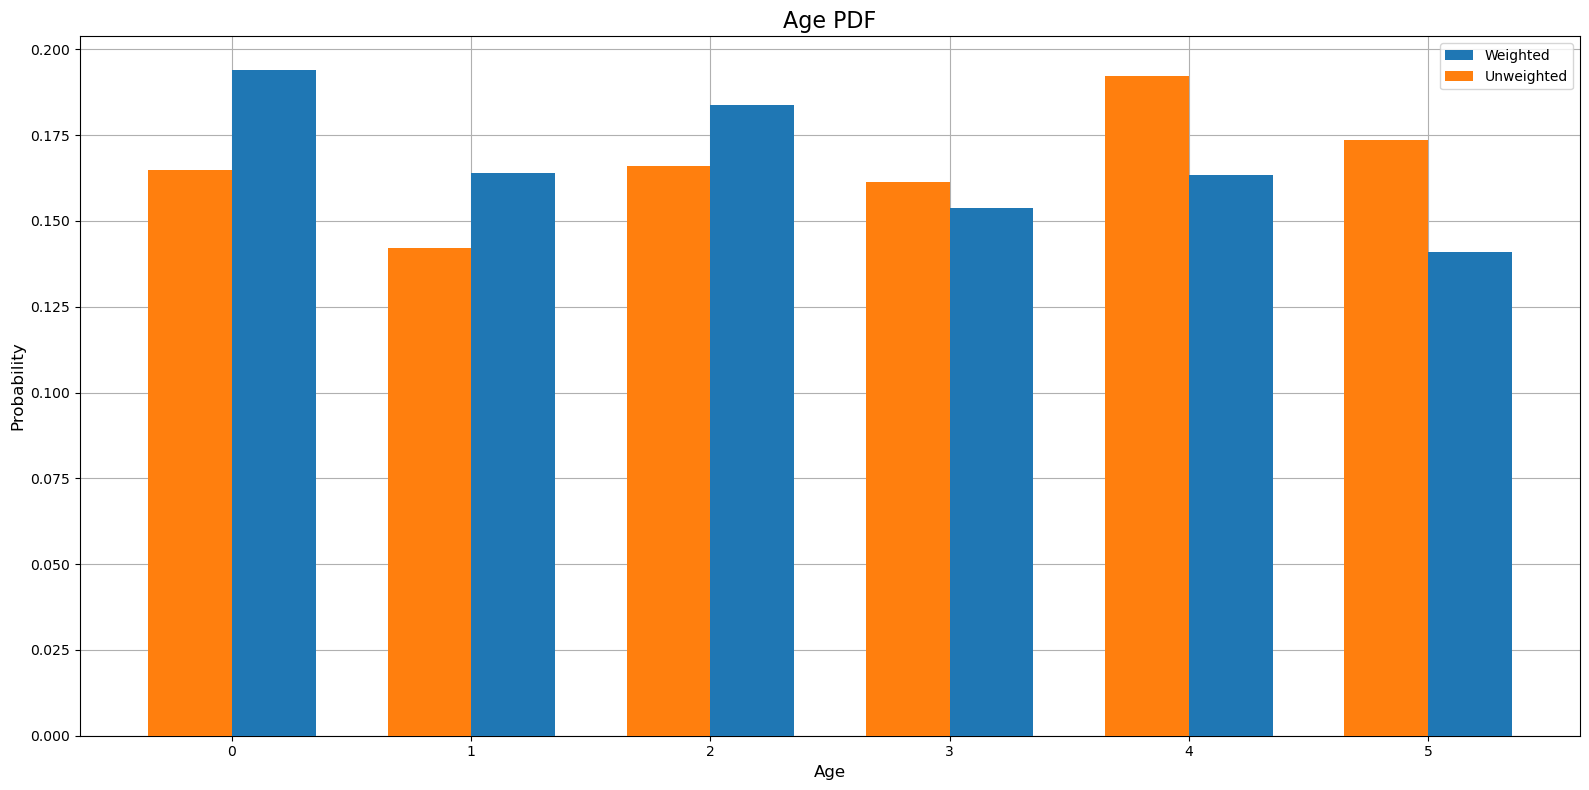

Unweighted PDF : [0.165 0.142 0.166 0.161 0.192 0.174]
  Weighted PDF : [0.194 0.164 0.184 0.154 0.163 0.141]


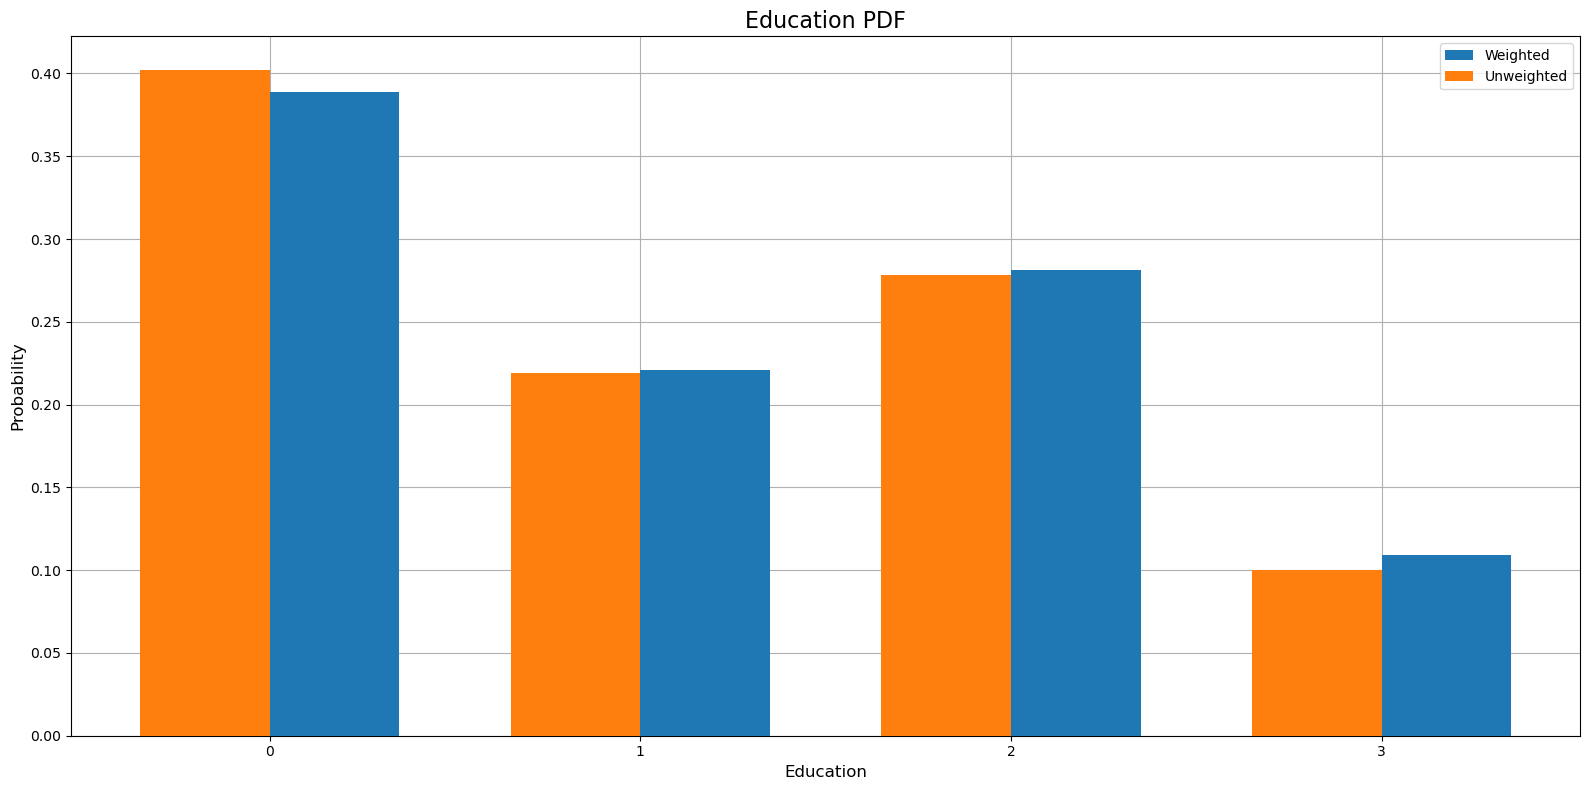

Unweighted PDF : [0.402 0.219 0.278 0.1  ]
  Weighted PDF : [0.389 0.221 0.281 0.109]


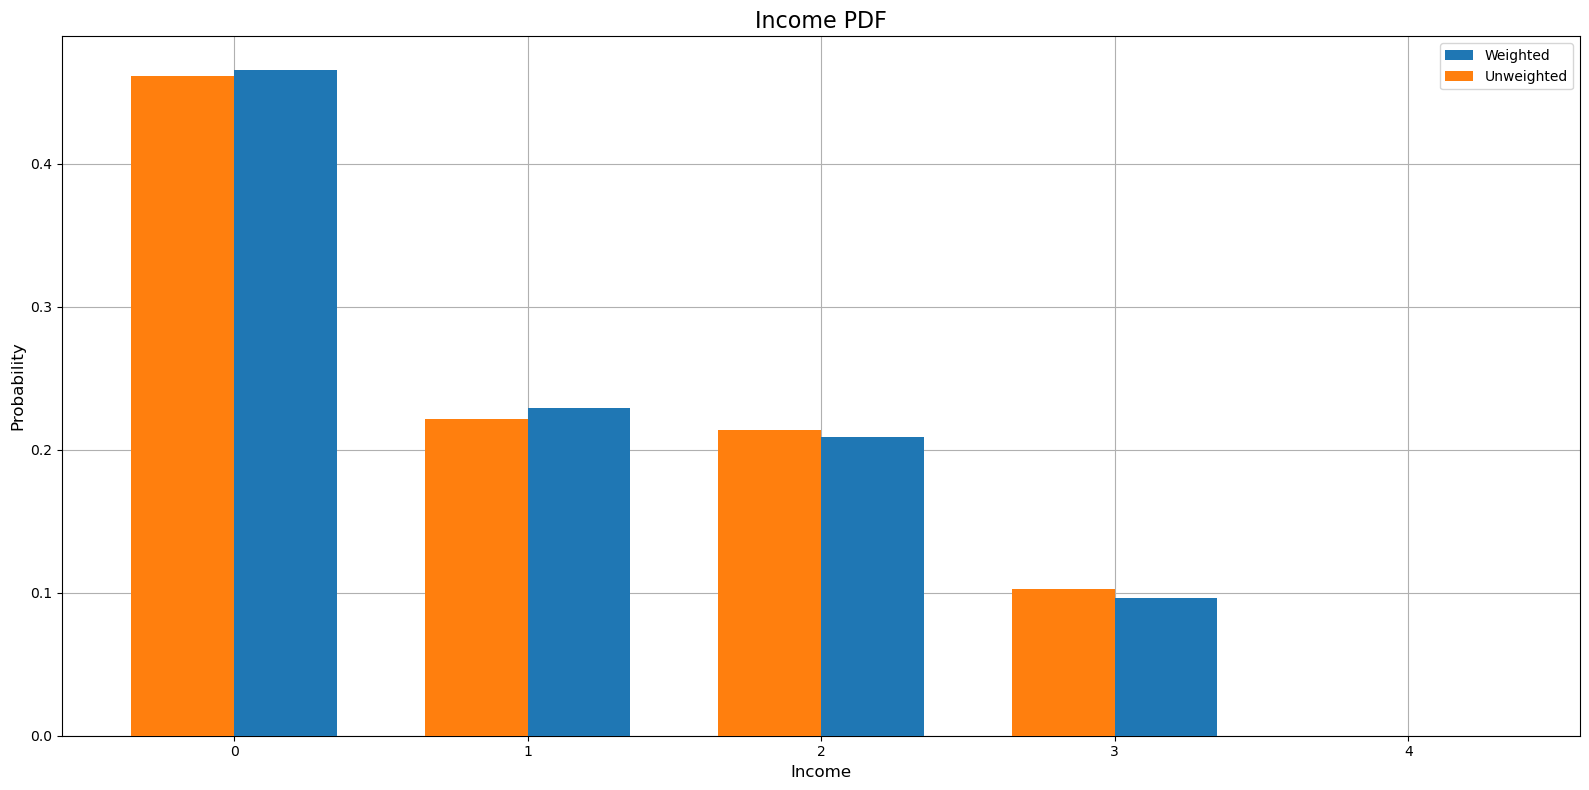

Unweighted PDF : [0.462 0.222 0.214 0.103 0.   ]
  Weighted PDF : [0.466 0.229 0.209 0.096 0.   ]


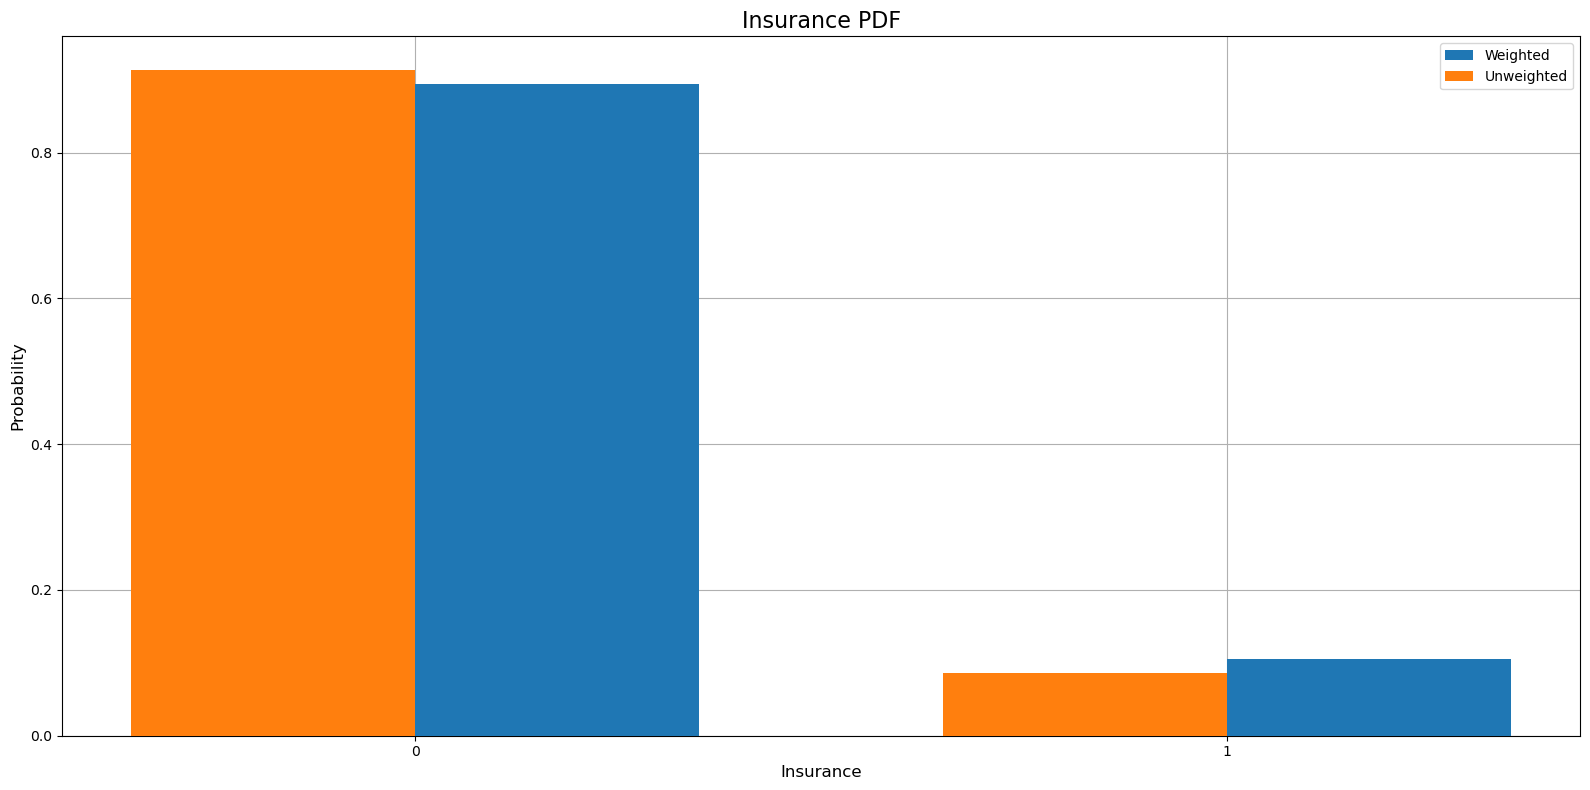

Unweighted PDF : [0.914 0.086]
  Weighted PDF : [0.894 0.106]


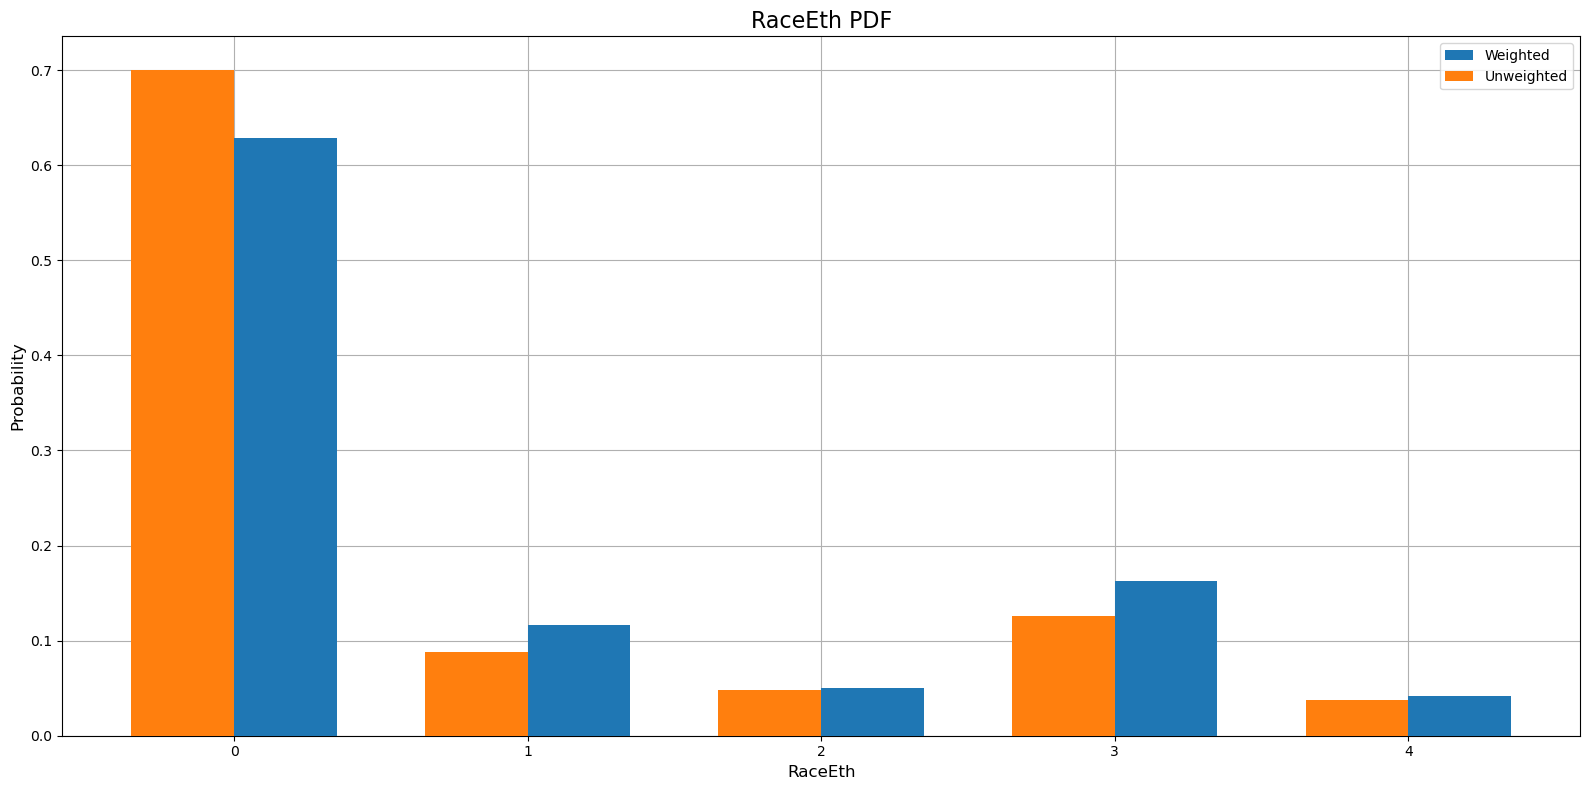

Unweighted PDF : [0.701 0.088 0.049 0.126 0.037]
  Weighted PDF : [0.628 0.117 0.05  0.163 0.042]


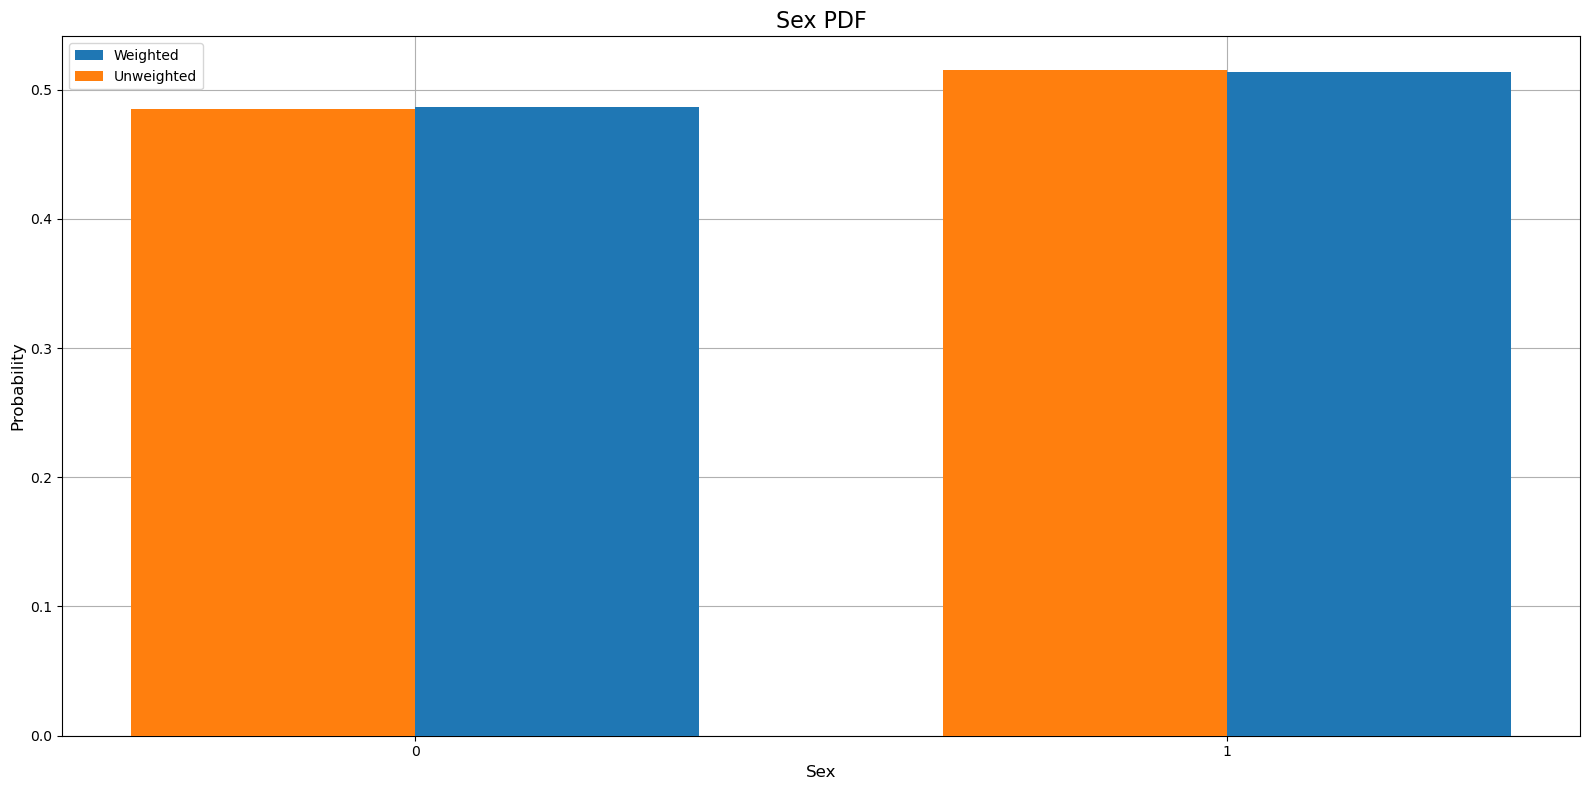

Unweighted PDF : [0.485 0.515]
  Weighted PDF : [0.487 0.513]


In [28]:
# display precision
P = 3

for col_name in final_df.columns:
    if col_name in NON_DATA_COLS:
        continue
        
    plots.dual_histogram_from_pdfs(col_name, unweighted_pdfs[col_name], weighted_pdfs[col_name],
                                   labels=['Unweighted', 'Weighted'])
    
    print('Unweighted PDF : {0}'.format(np.array_str(unweighted_pdfs[col_name], precision=P)))
    print('  Weighted PDF : {0}'.format(np.array_str(weighted_pdfs[col_name],   precision=P)))

#### Write recoded PUMS data to disk

In [29]:
# write to disk
f,e = os.path.splitext(INPUT_FILE)
output_file = f + '_recoded_aou_v2' + e
final_df.to_csv(output_file, index=False)
print('Wrote file "{0}".'.format(output_file))

Wrote file "data/pums_usa_2019_recoded_aou_v2.csv".


In [36]:
check_df = raw_df.copy()
# drop everybody less than 18
check_df = check_df.loc[check_df['AGEP'] >= 18]
check_df = check_df.reset_index(drop=True)

In [37]:
states = set(check_df['ST'].values)
for state_code in states:
    state_df = check_df.loc[check_df['ST'] == state_code]
    recoded_state_df = final_df.loc[final_df['ST'] == state_code]
    assert len(state_df) == len(recoded_state_df)

In [43]:
# check ages 18-49 for DIV_WNC
for state_code in [19, 20, 27, 29, 31, 38, 46]:
    state_df = check_df.loc[check_df['ST'] == state_code]
    age_values = state_df['AGEP'].values
    weights = state_df['PWGTP'].values
    sum_18_49 = 0
    for q, age in enumerate(age_values):
        int_age = int(age)
        if int_age >= 18 and int_age < 50:
            sum_18_49 += weights[q]
            
    print('State code: {0}, sum_18_49: {1}'.format(state_code, sum_18_49))

State code: 19, sum_18_49: 1277305
State code: 20, sum_18_49: 1199861
State code: 27, sum_18_49: 2314119
State code: 29, sum_18_49: 2503865
State code: 31, sum_18_49: 801301
State code: 38, sum_18_49: 332055
State code: 46, sum_18_49: 348641
